<a href="https://colab.research.google.com/github/FabioSicca/Organizacion-de-datos/blob/main/Parte3_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Parte III - Random Forest (5 puntos)**

Segun el paper con un clasificador basado en Random Forest deberiamos lograr un AUC de 1. Entrenar un Random Forest con búsqueda de hiperparametros que logre un AUC de 1 (¿cómo conviene elegir los datos de validación respecto de los de train?). El modelo debe cumplir las siguientes condiciones:

* Deben utilizar AUC-ROC como métrica de validación.
* Deben medirse solo en validación, no contra test!!!
* Deben ser reproducibles (correr el notebook varias veces no afecta al resultado).
* Deben tener un score en validación igual a 1.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
!pip install category_encoders
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders.binary import BinaryEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/secondary_data.csv', sep=";")

In [ ]:
X = df.drop('class', axis=1)
y = df['class']

In [ ]:
X_train_aux, X_test, y_train_aux, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_aux, y_train_aux, test_size=0.1, random_state=5)

In [ ]:
print(X_train.info(), X_validation.info(), X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49465 entries, 34760 to 57712
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          49465 non-null  float64
 1   cap-shape             49465 non-null  object 
 2   cap-surface           37940 non-null  object 
 3   cap-color             49465 non-null  object 
 4   does-bruise-or-bleed  49465 non-null  object 
 5   gill-attachment       41413 non-null  object 
 6   gill-spacing          29137 non-null  object 
 7   gill-color            49465 non-null  object 
 8   stem-height           49465 non-null  float64
 9   stem-width            49465 non-null  float64
 10  stem-root             7755 non-null   object 
 11  stem-surface          18525 non-null  object 
 12  stem-color            49465 non-null  object 
 13  veil-type             2598 non-null   object 
 14  veil-color            6043 non-null   object 
 15  has-ring       

#Feature Engineering y Encoding

Para poder realizar la comparación entre modelos necesito que el dataset sea el mismo para todos, por lo que uso el mismo feature engineering y encoding para todos los modelos.

##Relleno los NaNs

###Relleno NaNs en X_train

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49465 entries, 34760 to 57712
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          49465 non-null  float64
 1   cap-shape             49465 non-null  object 
 2   cap-surface           37940 non-null  object 
 3   cap-color             49465 non-null  object 
 4   does-bruise-or-bleed  49465 non-null  object 
 5   gill-attachment       41413 non-null  object 
 6   gill-spacing          29137 non-null  object 
 7   gill-color            49465 non-null  object 
 8   stem-height           49465 non-null  float64
 9   stem-width            49465 non-null  float64
 10  stem-root             7755 non-null   object 
 11  stem-surface          18525 non-null  object 
 12  stem-color            49465 non-null  object 
 13  veil-type             2598 non-null   object 
 14  veil-color            6043 non-null   object 
 15  has-ring       

Con esta información puedo ver qué columnas tienen NaNs y cuántos tienen.

In [ ]:
#En cap-surface tengo 11525 NaNs y en la documentación del dataset no hace referencia a que signifique nada particular
print(X_train.groupby("cap-surface").size())
#Los relleno con una nueva categoria "Unknown"
X_train["cap-surface"] = X_train["cap-surface"].fillna("unknown")

cap-surface
d    3524
e    2112
g    3806
h    4014
i    1806
k    1852
l    1153
s    6167
t    6629
w    1753
y    5124
dtype: int64


In [ ]:
#gill-attachment (8052 NaNs)
print(X_train.groupby("gill-attachment").size())
#Los relleno con "Unknown"
X_train["gill-attachment"] = X_train["gill-attachment"].fillna("unknown")

gill-attachment
a    10279
d     8281
e     4591
f     2862
p     4805
s     4590
x     6005
dtype: int64


In [ ]:
#gill-spacing (20328 NaNs)
print(X_train.groupby("gill-spacing").size())
X_train["gill-spacing"] = X_train["gill-spacing"].fillna("unknown")

gill-spacing
c    20024
d     6251
f     2862
dtype: int64


In [ ]:
#stem-root (41710 NaNs)
print(X_train.groupby("stem-root").size())
X_train["stem-root"] = X_train["stem-root"].fillna("unknown")

stem-root
b    2602
c     568
f     848
r    1144
s    2593
dtype: int64


In [ ]:
#stem-surface (30940 NaNs)
print(X_train.groupby("stem-surface").size())
X_train["stem-surface"] = X_train["stem-surface"].fillna("unknown")

stem-surface
f     848
g    1438
h     424
i    3535
k    1266
s    4862
t    2143
y    4009
dtype: int64


In [ ]:
#veil-type (46867 NaNs) Dado que solo hay de tipo u=universal, se asume que los NaNs=partial por lo que se reemplazan con p
print(X_train.groupby("veil-type").size())
X_train["veil-type"] = X_train["veil-type"].fillna("p")

veil-type
u    2598
dtype: int64


In [ ]:
#veil-color (43422 NaNs) Como según el dataset f=none, NaN podría ser Unknown
print(X_train.groupby("veil-color").size())
X_train["veil-color"] = X_train["veil-color"].fillna("unknown")

veil-color
e     151
k     292
n     416
u     286
w    4465
y     433
dtype: int64


In [ ]:
#ring-type (1974 NaNs) Como f representa casi el total, puedo reemplazar los "pocos" faltantes por f,
#además el dataset indica que los NaNs hacen referencia a que no se sabe el tipo de dato, por lo que no está mal rellenarlo.
print(X_train.groupby("ring-type").size())
X_train["ring-type"] = X_train["ring-type"].fillna("f")

ring-type
e     1959
f    39108
g     1025
l     1165
m      292
p     1035
r     1155
z     1711
dtype: int64


In [ ]:
#spore-print-color (44316 NaNs)
print(X_train.groupby("spore-print-color").size())
#Podria intentar rellenarlo aleatoriamente con fillna(method='ffill'), pero hay demasiados NaNs, por lo que uso "unknown"
X_train["spore-print-color"] = X_train["spore-print-color"].fillna("unknown")

spore-print-color
g     294
k    1715
n     852
p    1013
r     140
u     152
w     983
dtype: int64


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49465 entries, 34760 to 57712
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          49465 non-null  float64
 1   cap-shape             49465 non-null  object 
 2   cap-surface           49465 non-null  object 
 3   cap-color             49465 non-null  object 
 4   does-bruise-or-bleed  49465 non-null  object 
 5   gill-attachment       49465 non-null  object 
 6   gill-spacing          49465 non-null  object 
 7   gill-color            49465 non-null  object 
 8   stem-height           49465 non-null  float64
 9   stem-width            49465 non-null  float64
 10  stem-root             49465 non-null  object 
 11  stem-surface          49465 non-null  object 
 12  stem-color            49465 non-null  object 
 13  veil-type             49465 non-null  object 
 14  veil-color            49465 non-null  object 
 15  has-ring       

Entonces ahora se puede ver que el dataset X_train ya no tiene valores NaNs

### Relleno los NaNs en X_validation

In [ ]:
X_validation["cap-surface"] = X_validation["cap-surface"].fillna("unknown")
X_validation["gill-attachment"] = X_validation["gill-attachment"].fillna("unknown")
X_validation["gill-spacing"] = X_validation["gill-spacing"].fillna("unknown")
X_validation["stem-root"] = X_validation["stem-root"].fillna("unknown")
X_validation["stem-surface"] = X_validation["stem-surface"].fillna("unknown")
X_validation["veil-type"] = X_validation["veil-type"].fillna("p")
X_validation["veil-color"] = X_validation["veil-color"].fillna("unknown")
X_validation["ring-type"] = X_validation["ring-type"].fillna("f")
X_validation["spore-print-color"] = X_validation["spore-print-color"].fillna("unknown")

In [ ]:
X_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5497 entries, 35132 to 58126
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          5497 non-null   float64
 1   cap-shape             5497 non-null   object 
 2   cap-surface           5497 non-null   object 
 3   cap-color             5497 non-null   object 
 4   does-bruise-or-bleed  5497 non-null   object 
 5   gill-attachment       5497 non-null   object 
 6   gill-spacing          5497 non-null   object 
 7   gill-color            5497 non-null   object 
 8   stem-height           5497 non-null   float64
 9   stem-width            5497 non-null   float64
 10  stem-root             5497 non-null   object 
 11  stem-surface          5497 non-null   object 
 12  stem-color            5497 non-null   object 
 13  veil-type             5497 non-null   object 
 14  veil-color            5497 non-null   object 
 15  has-ring        

###Relleno los NaNs en X_test

Ahora relleno los NaNs de X_test (Se hace por separado para que no se pueda filtrar información del train_set al test_set)

In [ ]:
print(X_test.groupby("cap-surface").size())
#Los relleno con una nueva categoria "Unknown"
X_test["cap-surface"] = X_test["cap-surface"].fillna("unknown")

cap-surface
d    467
e    250
g    479
h    504
i    212
k    224
l    139
s    784
t    820
w    200
y    627
dtype: int64


In [ ]:
print(X_test.groupby("gill-attachment").size())
#Los relleno con "Unknown"
X_test["gill-attachment"] = X_test["gill-attachment"].fillna("unknown")

gill-attachment
a    1292
d    1030
e     572
f     365
p     620
s     553
x     720
dtype: int64


In [ ]:
print(X_test.groupby("gill-spacing").size())
X_test["gill-spacing"] = X_test["gill-spacing"].fillna("unknown")

gill-spacing
c    2462
d     784
f     365
dtype: int64


In [ ]:
print(X_test.groupby("stem-root").size())
X_test["stem-root"] = X_test["stem-root"].fillna("unknown")

stem-root
b    289
c     78
f    125
r    132
s    315
dtype: int64


In [ ]:
print(X_test.groupby("stem-surface").size())
X_test["stem-surface"] = X_test["stem-surface"].fillna("unknown")

stem-surface
f    125
g    173
h     69
i    445
k    158
s    630
t    260
y    491
dtype: int64


In [ ]:
print(X_test.groupby("veil-type").size())
X_test["veil-type"] = X_test["veil-type"].fillna("p")

veil-type
u    318
dtype: int64


In [ ]:
print(X_test.groupby("veil-color").size())
X_test["veil-color"] = X_test["veil-color"].fillna("unknown")

veil-color
e     14
k     32
n     68
u     38
w    550
y     40
dtype: int64


In [ ]:
print(X_test.groupby("ring-type").size())
X_test["ring-type"] = X_test["ring-type"].fillna("f")

ring-type
e     257
f    4860
g     120
l     145
m      30
p     119
r     132
z     232
dtype: int64


In [ ]:
print(X_test.groupby("spore-print-color").size())
X_test["spore-print-color"] = X_test["spore-print-color"].fillna("unknown")

spore-print-color
g     34
k    225
n    105
p    132
r     17
u     16
w    114
dtype: int64


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6107 entries, 39238 to 18221
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          6107 non-null   float64
 1   cap-shape             6107 non-null   object 
 2   cap-surface           6107 non-null   object 
 3   cap-color             6107 non-null   object 
 4   does-bruise-or-bleed  6107 non-null   object 
 5   gill-attachment       6107 non-null   object 
 6   gill-spacing          6107 non-null   object 
 7   gill-color            6107 non-null   object 
 8   stem-height           6107 non-null   float64
 9   stem-width            6107 non-null   float64
 10  stem-root             6107 non-null   object 
 11  stem-surface          6107 non-null   object 
 12  stem-color            6107 non-null   object 
 13  veil-type             6107 non-null   object 
 14  veil-color            6107 non-null   object 
 15  has-ring        

##Encodeo los features

Uso BinaryEncoding para aquellas columnas que tienen muchas categorías diferentes (como los colores) y OneHotEncoding para aquellas que no

In [ ]:
def hot_encode(column_name, train_set, validation_set, test_set):
  ohe = OneHotEncoder() #drop='first'

  encoded_matrix = ohe.fit_transform(X_train[[column_name]]).todense().astype(int)
  encoded_matrix_validation = ohe.transform(X_validation[[column_name]]).todense().astype(int)
  encoded_matrix_test = ohe.transform(X_test[[column_name]]).todense().astype(int)

  train_set = train_set.reset_index().drop(['index', column_name],axis=1).join(pd.DataFrame(encoded_matrix, columns=list(ohe.get_feature_names_out())))
  validation_set = validation_set.reset_index().drop(['index', column_name],axis=1).join(pd.DataFrame(encoded_matrix_validation, columns=list(ohe.get_feature_names_out())))
  test_set = test_set.reset_index().drop(['index', column_name],axis=1).join(pd.DataFrame(encoded_matrix_test, columns=list(ohe.get_feature_names_out())))

  return train_set, validation_set, test_set


def binary_encode(column_name, train_set, validation_set, test_set):
  binary_encoder = BinaryEncoder()

  encoded_column = binary_encoder.fit_transform(train_set[[column_name]]).astype(int)
  encoded_column_validation = binary_encoder.transform(validation_set[[column_name]]).astype(int)
  encoded_column_test = binary_encoder.transform(test_set[[column_name]]).astype(int)

  train_set = train_set.drop(columns=[column_name])
  train_set = train_set.join(encoded_column)

  validation_set = validation_set.drop(columns=[column_name])
  validation_set = validation_set.join(encoded_column_validation)

  test_set = test_set.drop(columns=[column_name])
  test_set = test_set.join(encoded_column_test)

  return train_set, validation_set, test_set

In [ ]:
X_train, X_validation, X_test = binary_encode("cap-color", X_train, X_validation, X_test)
X_train, X_validation, X_test = binary_encode("gill-color", X_train, X_validation, X_test)
X_train, X_validation, X_test = binary_encode("spore-print-color", X_train, X_validation, X_test)
X_train, X_validation, X_test = binary_encode("stem-color", X_train, X_validation, X_test)

X_train, X_validation, X_test = hot_encode("cap-shape", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("cap-surface", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("does-bruise-or-bleed", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("gill-attachment", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("gill-spacing", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("stem-root", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("stem-surface", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("veil-type", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("veil-color", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("has-ring", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("ring-type", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("habitat", X_train, X_validation, X_test)
X_train, X_validation, X_test = hot_encode("season", X_train, X_validation, X_test)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49465 entries, 0 to 49464
Data columns (total 98 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cap-diameter             49465 non-null  float64
 1   stem-height              49465 non-null  float64
 2   stem-width               49465 non-null  float64
 3   cap-color_0              49465 non-null  int64  
 4   cap-color_1              49465 non-null  int64  
 5   cap-color_2              49465 non-null  int64  
 6   cap-color_3              49465 non-null  int64  
 7   gill-color_0             49465 non-null  int64  
 8   gill-color_1             49465 non-null  int64  
 9   gill-color_2             49465 non-null  int64  
 10  gill-color_3             49465 non-null  int64  
 11  spore-print-color_0      49465 non-null  int64  
 12  spore-print-color_1      49465 non-null  int64  
 13  spore-print-color_2      49465 non-null  int64  
 14  spore-print-color_3   

In [ ]:
X_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5497 entries, 0 to 5496
Data columns (total 98 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cap-diameter             5497 non-null   float64
 1   stem-height              5497 non-null   float64
 2   stem-width               5497 non-null   float64
 3   cap-color_0              5497 non-null   int64  
 4   cap-color_1              5497 non-null   int64  
 5   cap-color_2              5497 non-null   int64  
 6   cap-color_3              5497 non-null   int64  
 7   gill-color_0             5497 non-null   int64  
 8   gill-color_1             5497 non-null   int64  
 9   gill-color_2             5497 non-null   int64  
 10  gill-color_3             5497 non-null   int64  
 11  spore-print-color_0      5497 non-null   int64  
 12  spore-print-color_1      5497 non-null   int64  
 13  spore-print-color_2      5497 non-null   int64  
 14  spore-print-color_3     

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6107 entries, 0 to 6106
Data columns (total 98 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cap-diameter             6107 non-null   float64
 1   stem-height              6107 non-null   float64
 2   stem-width               6107 non-null   float64
 3   cap-color_0              6107 non-null   int64  
 4   cap-color_1              6107 non-null   int64  
 5   cap-color_2              6107 non-null   int64  
 6   cap-color_3              6107 non-null   int64  
 7   gill-color_0             6107 non-null   int64  
 8   gill-color_1             6107 non-null   int64  
 9   gill-color_2             6107 non-null   int64  
 10  gill-color_3             6107 non-null   int64  
 11  spore-print-color_0      6107 non-null   int64  
 12  spore-print-color_1      6107 non-null   int64  
 13  spore-print-color_2      6107 non-null   int64  
 14  spore-print-color_3     

###Mapeo los valores de y_train, y_validation e y_test por 0's y 1's

In [ ]:
y_train = y_train.map({"e":0,"p":1})

In [ ]:
y_validation = y_validation.map({"e":0, "p":1})

In [ ]:
y_test = y_test.map({"e":0,"p":1})

#Modelo Random Forest

**HIPERPARÁMETROS DEL RANDOM FOREST:**

*   **n_estimators**: cantidad de árboles a construir (100)
*   **max_depth**: máxima profundidad de cada árbol
*   **min_samples_split**: la cantidad mínima de datos requeridos para splitear un nodo interno (2)
*   **min_samples_leaf**: cantidad mínima de datos requeridos para ser una hoja (1)
*   **max_features**: la cantidad de features a considerar cuando se busca el mejor split (n)



In [ ]:
rf_model = RandomForestClassifier(random_state=5)
rf_model.fit(X_train, y_train)
y_pred_val = rf_model.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, y_pred_val))
print("RMSE: %f" % (rmse))

RMSE: 0.000000


Dado que con los hiperparámetros estándar el modelo funciona óptimamente, no es necesaria la búsqueda de hiperparámetros como en la parte 2, si esto no hubiera sucedido, tendría que realizar un GridSearch, un RandomSearch o buscarlos "manualmente"

In [ ]:
rf_model.get_params(deep=True) #Hiperparámetros estándar

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 5,
 'verbose': 0,
 'warm_start': False}

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score

In [ ]:
y_validation = y_validation.astype(int)

In [ ]:
cm = confusion_matrix(y_validation, y_pred_val)
cm

array([[2477,    0],
       [   0, 3020]])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
roc_auc_score(y_validation, rf_model.predict_proba(X_validation)[:, 1])

1.0

In [ ]:
!pip install scikit-plot
import scikitplot as skplt
import matplotlib.pyplot as plt

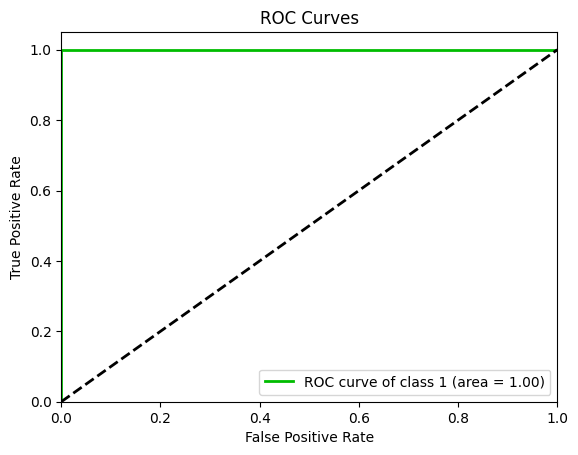

In [ ]:
skplt.metrics.plot_roc(y_validation, rf_model.predict_proba(X_validation),classes_to_plot= 1,plot_micro= False, plot_macro = False)
plt.show()

Como se puede ver (y como marcaba en el paper) con un modelo RandomForest, el problema alcanza un AUC-ROC igual a 1

# Punto extra:

Graficar la importancia de features para el Random Forest de la parte III. ¿Qué tanto se parece a los features importantes de la parte II?

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49465 entries, 0 to 49464
Data columns (total 98 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cap-diameter             49465 non-null  float64
 1   stem-height              49465 non-null  float64
 2   stem-width               49465 non-null  float64
 3   cap-color_0              49465 non-null  int64  
 4   cap-color_1              49465 non-null  int64  
 5   cap-color_2              49465 non-null  int64  
 6   cap-color_3              49465 non-null  int64  
 7   gill-color_0             49465 non-null  int64  
 8   gill-color_1             49465 non-null  int64  
 9   gill-color_2             49465 non-null  int64  
 10  gill-color_3             49465 non-null  int64  
 11  spore-print-color_0      49465 non-null  int64  
 12  spore-print-color_1      49465 non-null  int64  
 13  spore-print-color_2      49465 non-null  int64  
 14  spore-print-color_3   

In [ ]:
rf_model.feature_importances_

array([5.33784058e-02, 5.31972028e-02, 8.18864725e-02, 7.90723546e-03,
       1.64341611e-02, 1.36548898e-02, 1.42268788e-02, 1.39342167e-02,
       1.37957465e-02, 1.67439613e-02, 1.87617167e-02, 1.66398251e-04,
       4.02612515e-03, 1.03686234e-02, 4.36592143e-03, 5.29439946e-03,
       7.35637225e-03, 2.12263945e-02, 2.39174766e-02, 1.27994668e-02,
       6.41268057e-03, 9.33398370e-03, 4.64482630e-03, 3.37759461e-03,
       5.05577209e-03, 1.41330585e-02, 8.75416865e-03, 7.51053767e-03,
       1.10793355e-02, 7.97854458e-03, 5.17239553e-03, 1.10322511e-02,
       4.72257258e-03, 1.24540676e-02, 1.20969935e-02, 1.34365027e-02,
       5.06818004e-03, 9.83817118e-03, 1.41860125e-02, 1.51858967e-02,
       1.26086553e-02, 1.50927606e-02, 1.14953188e-02, 5.42602936e-03,
       2.11339878e-02, 1.07622750e-02, 1.21816367e-02, 1.40707475e-02,
       2.25328160e-02, 2.65041430e-02, 3.56386047e-03, 2.10274305e-02,
       9.27599498e-03, 9.17349251e-03, 8.08195854e-04, 1.20988407e-02,
      

In [ ]:
def sum_abs_values(importances, begin, end):
  importance = 0
  for i in range(begin, end+1):
    importance += abs(importances[i])
  return importance

features_imp = rf_model.feature_importances_

features_importance = []
features_importance.append(abs(features_imp[0]))
features_importance.append(abs(features_imp[1]))
features_importance.append(abs(features_imp[2]))
features_importance.append(sum_abs_values(features_imp, 3, 6))
features_importance.append(sum_abs_values(features_imp, 7, 10))
features_importance.append(sum_abs_values(features_imp, 11, 14))
features_importance.append(sum_abs_values(features_imp, 15, 18))
features_importance.append(sum_abs_values(features_imp, 19, 25))
features_importance.append(sum_abs_values(features_imp, 26, 37))
features_importance.append(sum_abs_values(features_imp, 38, 39))
features_importance.append(sum_abs_values(features_imp, 40, 47))
features_importance.append(sum_abs_values(features_imp, 48, 51))
features_importance.append(sum_abs_values(features_imp, 52, 57))
features_importance.append(sum_abs_values(features_imp, 58, 66))
features_importance.append(sum_abs_values(features_imp, 67, 68))
features_importance.append(sum_abs_values(features_imp, 69, 75))
features_importance.append(sum_abs_values(features_imp, 76, 77))
features_importance.append(sum_abs_values(features_imp, 78, 85))
features_importance.append(sum_abs_values(features_imp, 86, 93))
features_importance.append(sum_abs_values(features_imp, 94, 97))

features_importance

[0.053378405771265375,
 0.05319720278105422,
 0.0818864724851588,
 0.05222316511112668,
 0.06323564117755082,
 0.018927068191477374,
 0.05779464286421009,
 0.055757382572780914,
 0.1091437206939728,
 0.02937190915369388,
 0.10277141102614282,
 0.07362825003812519,
 0.05142060749717786,
 0.07373596164107453,
 0.008247063096535607,
 0.01833820402786969,
 0.024586633204711945,
 0.033379806473333926,
 0.026493562784041004,
 0.012482889408696657]

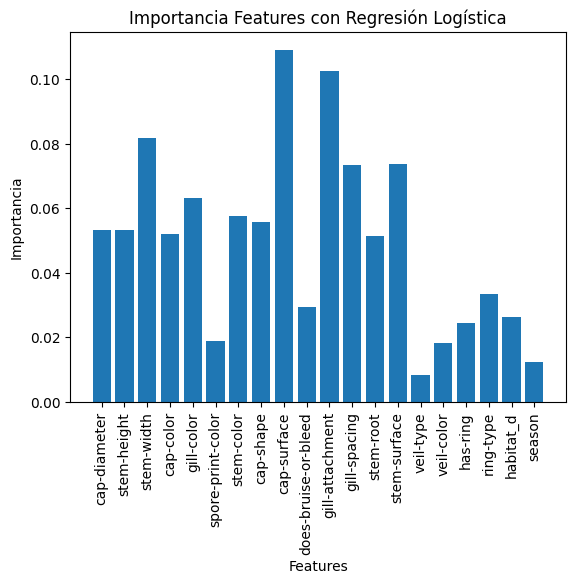

In [ ]:
features = ['cap-diameter','stem-height','stem-width','cap-color','gill-color','spore-print-color','stem-color',
       'cap-shape', 'cap-surface','does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'stem-root',
       'stem-surface', 'veil-type','veil-color', 'has-ring', 'ring-type', 'habitat_d', 'season']
plt.bar(features, features_importance)
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importancia')
plt.title('Importancia Features con Regresión Logística')
plt.show()

Vemos que en comparación con la feature importance del modelo de regresión logística, los valores son totalmente diferentes, esto nos demuestra que cada modelo le da una importancia diferente a cada feature. Mientras que la regresión logística consideraba la feature más importante el 'veil-color', el random forest no le otorga mucha importancia, en cambio considera que la features más importantes son el 'cap-surface' y el 'gill-attachment'

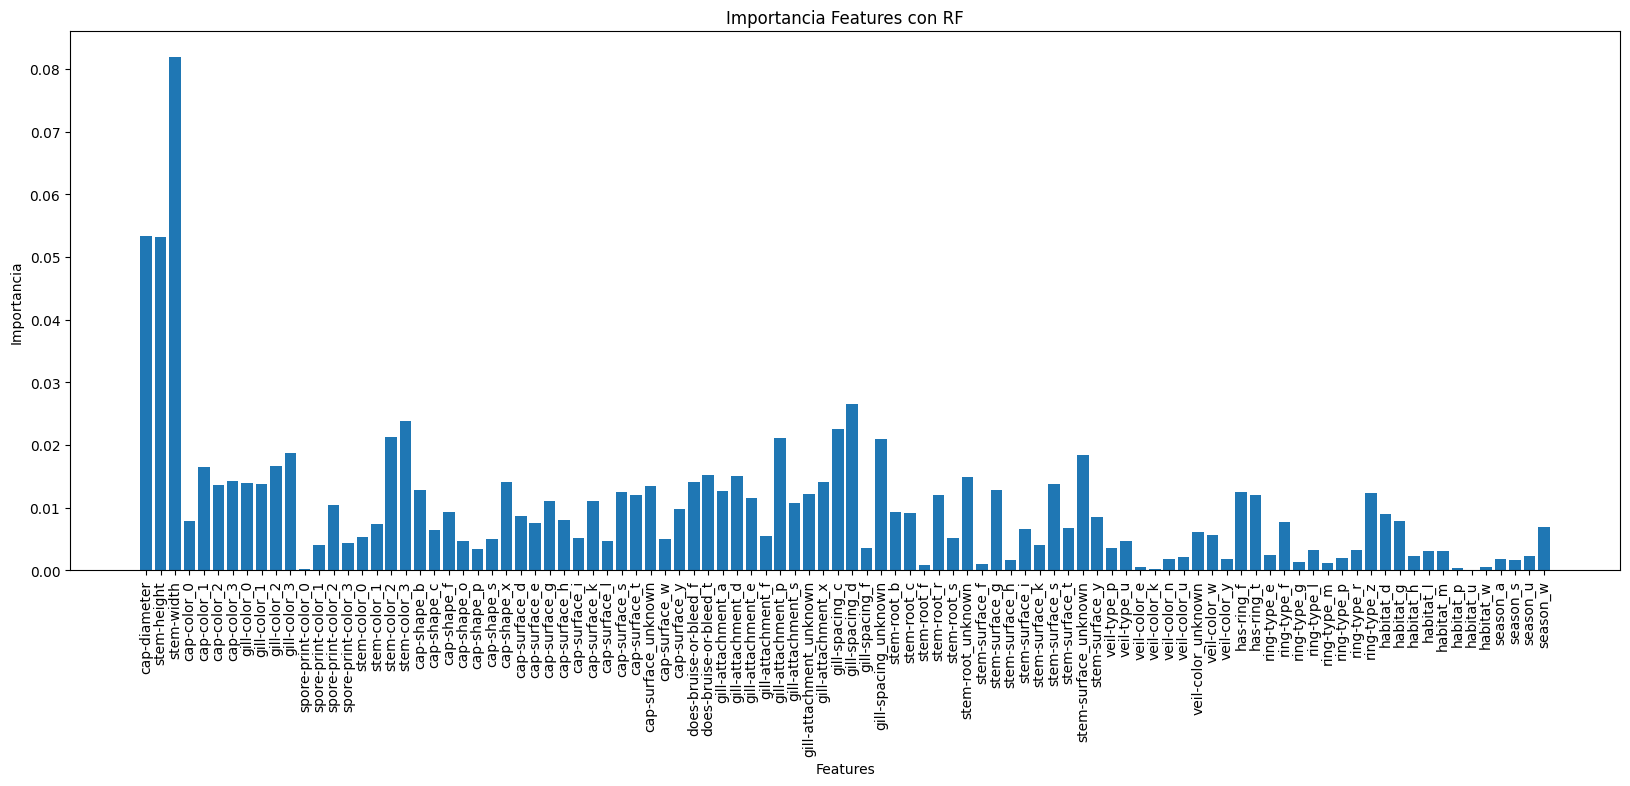

In [ ]:
plt.figure(figsize=(20,7))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

Este último plot solo sirve para ver que los resultados de las sumas de los features sean correctos y tengan sentido. Se puede notar como parece que la feature más importante es el 'stem-width', pero al hacer la suma de todos los 'cap-surface', estos lo superan.